## xgboost

### 载入包、导入数据

In [253]:
import numpy as np
import pandas as pd
import xgboost as xgb
from matplotlib import pylab as plt
from sklearn.cross_validation import train_test_split
from sklearn.metrics import roc_curve, auc
df=pd.read_pickle('0621_YF_v3_data_with_score.pkl')

### xgb数据预处理

In [254]:
fea_in = ['account_reg_time', 'age', 'consumer_label_if_pay_ins', 'individual_gender', 'jd_score', 'kx_score', 'phone_reg_time', 'r_woe_channel_name_1', 'r_woe_prea_v5_fico', 'r_woe_province', 'r_woe_xy_score', 'td_count_7d', 'user_gray_contacts_gray_score_be_mean', 'user_gray_contacts_gray_score_to_min', 'user_gray_contacts_number_statistic_cnt_be_all', 'user_gray_contacts_number_statistic_cnt_to_applied', 'user_gray_contacts_number_statistic_pct_cnt_be_all', 'user_gray_contacts_number_statistic_pct_cnt_to_applied', 'user_gray_contacts_query_to_query_cnt_12', 'user_gray_contacts_query_to_query_cnt_6', 'user_gray_contacts_rfm_call_cnt_be_all', 'user_gray_phone_gray_score', 'user_gray_weight_all', 'user_gray_weight_to_all', 'user_searched_history_by_day_d_15_cnt_org', 'user_searched_history_by_day_d_7_cnt', 'user_searched_history_by_day_d_7_cnt_cash', 'user_searched_history_by_day_d_7_pct_cnt_all', 'user_searched_history_by_day_m_24_cnt', 'user_searched_history_by_day_m_24_cnt_cash', 'user_searched_history_by_day_m_24_cnt_org_cf']
feature=df[fea_in]
#feature=feature.sort_values(by='kx_score',axis=0,ascending=True)
feature['kx_score']=pd.qcut(feature['kx_score'],10,labels=False)+1
label=df['14d']
#feature.isnull().sum()

/data1/jupyterhub/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


### kx训练集测试集划分

In [232]:
train_x, test_x, train_y, test_y = train_test_split(feature, label, random_state=0, test_size = 0.2)
dtrain=xgb.DMatrix(train_x,label=train_y)
dtest=xgb.DMatrix(test_x)

### 模型训练

In [233]:
bst=xgb.XGBClassifier()
bst.fit(train_x,train_y,eval_metric='auc')

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

### 特征重要性输出

In [234]:
#dtrain_predictions = bst.predict(test_x)
#dtrain_predprob = bst.predict_proba(test_x)[:,1]
#plot_importance(bst)
#plt.show()
featureimportance=pd.concat([pd.DataFrame(bst.feature_importances_.tolist(),columns=['importance']),pd.DataFrame(fea_in,columns=['feature_name'])],axis=1)
featureimportance.sort_values(by = 'importance',axis = 0,ascending = False)

,importance,feature_name
10,0.148571,r_woe_xy_score
28,0.072857,user_searched_history_by_day_m_24_cnt
5,0.067143,kx_score
25,0.058571,user_searched_history_by_day_d_7_cnt
4,0.054286,jd_score
12,0.047143,user_gray_contacts_gray_score_be_mean
6,0.042857,phone_reg_time
7,0.040000,r_woe_channel_name_1
2,0.037143,consumer_label_if_pay_ins
16,0.034286,user_gray_contacts_number_statistic_pct_cnt_be...


### 模型预测

In [235]:
dtrain_predictions = bst.predict(train_x)
dtrain_predprob = bst.predict_proba(train_x)[:,1]
dtest_predictions = bst.predict(test_x)
dtest_predprob = bst.predict_proba(test_x)[:,1]

### 模型评价

In [236]:
#训练集模型评价
false_positive_rate_train, true_positive_rate_train, thresholds_train = roc_curve(train_y, dtrain_predprob ) 
roc_auc_train = auc(false_positive_rate_train, true_positive_rate_train)
ks_train = abs(false_positive_rate_train-true_positive_rate_train).max()
#预测集模型评价
false_positive_rate_test, true_positive_rate_test, thresholds_test = roc_curve(test_y, dtest_predprob ) 
roc_auc_test = auc(false_positive_rate_test, true_positive_rate_test)
# plt.plot(false_positive_rate, true_positive_rate, 'b',
# label='AUC = %0.2f'% roc_auc)
# plt.legend(loc='lower right')
# plt.plot([0,1],[0,1],'r--')
# plt.xlim([-0.1,1.2])
# plt.ylim([-0.1,1.2])
# plt.ylabel('True Positive Rate')
# plt.xlabel('False Positive Rate')
# plt.show()
ks_test = abs(false_positive_rate_test-true_positive_rate_test).max()


### OOT

In [237]:
fea_in = ['model_ind','account_reg_time', 'age', 'consumer_label_if_pay_ins', 'individual_gender', 'jd_score', 'kx_score', 'phone_reg_time', 'r_woe_channel_name_1', 'r_woe_prea_v5_fico', 'r_woe_province', 'r_woe_xy_score', 'td_count_7d', 'user_gray_contacts_gray_score_be_mean', 'user_gray_contacts_gray_score_to_min', 'user_gray_contacts_number_statistic_cnt_be_all', 'user_gray_contacts_number_statistic_cnt_to_applied', 'user_gray_contacts_number_statistic_pct_cnt_be_all', 'user_gray_contacts_number_statistic_pct_cnt_to_applied', 'user_gray_contacts_query_to_query_cnt_12', 'user_gray_contacts_query_to_query_cnt_6', 'user_gray_contacts_rfm_call_cnt_be_all', 'user_gray_phone_gray_score', 'user_gray_weight_all', 'user_gray_weight_to_all', 'user_searched_history_by_day_d_15_cnt_org', 'user_searched_history_by_day_d_7_cnt', 'user_searched_history_by_day_d_7_cnt_cash', 'user_searched_history_by_day_d_7_pct_cnt_all', 'user_searched_history_by_day_m_24_cnt', 'user_searched_history_by_day_m_24_cnt_cash', 'user_searched_history_by_day_m_24_cnt_org_cf']
feature=df[fea_in]
feature['kx_score']=pd.qcut(feature['kx_score'],10,labels=False)+1
label=df[['model_ind','14d']]
train=feature[feature['model_ind']!='O']
test=feature[feature['model_ind']=='O']
train=train.drop(['model_ind'],axis=1)
test=test.drop(['model_ind'],axis=1)
train_y1=label[label['model_ind']!='O']
test_y1=label[label['model_ind']=='O']
train_y1=train_y1.drop(['model_ind'],axis=1)
test_y1=test_y1.drop(['model_ind'],axis=1)
bst1=xgb.XGBClassifier()
bst1.fit(train,train_y1,eval_metric='auc')
doot_predictions = bst1.predict(test)
doot_predprob = bst1.predict_proba(test)[:,1]
false_positive_rate_oot, true_positive_rate_oot, thresholds_oot = roc_curve(test_y1, doot_predprob ) 
roc_auc_oot = auc(false_positive_rate_oot, true_positive_rate_oot)
ks_oot = abs(false_positive_rate_oot-true_positive_rate_oot).max()

/data1/jupyterhub/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/data1/jupyterhub/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:112: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/data1/jupyterhub/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:147: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [238]:
def PlotKS(preds, labels, n, asc):

    # preds is score: asc=1
    # preds is prob: asc=0

    pred = preds  # 预测值
    bad = labels  # 取1为bad, 0为good
    ksds = pd.DataFrame({'bad': bad, 'pred': pred})
    ksds['good'] = 1 - ksds.bad

    if asc == 1:
        ksds1 = ksds.sort_values(by=['pred', 'bad'], ascending=[True, True])
    elif asc == 0:
        ksds1 = ksds.sort_values(by=['pred', 'bad'], ascending=[False, True])
    ksds1.index = range(len(ksds1.pred))
    ksds1['cumsum_good1'] = 1.0*ksds1.good.cumsum()/sum(ksds1.good)
    ksds1['cumsum_bad1'] = 1.0*ksds1.bad.cumsum()/sum(ksds1.bad)

    if asc == 1:
        ksds2 = ksds.sort_values(by=['pred', 'bad'], ascending=[True, False])
    elif asc == 0:
        ksds2 = ksds.sort_values(by=['pred', 'bad'], ascending=[False, False])
    ksds2.index = range(len(ksds2.pred))
    ksds2['cumsum_good2'] = 1.0*ksds2.good.cumsum()/sum(ksds2.good)
    ksds2['cumsum_bad2'] = 1.0*ksds2.bad.cumsum()/sum(ksds2.bad)

    # ksds1 ksds2 -> average
    ksds = ksds1[['cumsum_good1', 'cumsum_bad1']]
    ksds['cumsum_good2'] = ksds2['cumsum_good2']
    ksds['cumsum_bad2'] = ksds2['cumsum_bad2']
    ksds['cumsum_good'] = (ksds['cumsum_good1'] + ksds['cumsum_good2'])/2
    ksds['cumsum_bad'] = (ksds['cumsum_bad1'] + ksds['cumsum_bad2'])/2

    # ks
    ksds['ks'] = ksds['cumsum_bad'] - ksds['cumsum_good']
    ksds['tile0'] = range(1, len(ksds.ks) + 1)
    ksds['tile'] = 1.0*ksds['tile0']/len(ksds['tile0'])

    qe = list(np.arange(0, 1, 1.0/n))
    qe.append(1)
    qe = qe[1:]

    ks_index = pd.Series(ksds.index)
    ks_index = ks_index.quantile(q = qe)
    ks_index = np.ceil(ks_index).astype(int)
    ks_index = list(ks_index)

    ksds = ksds.loc[ks_index]
    ksds = ksds[['tile', 'cumsum_good', 'cumsum_bad', 'ks']]
    ksds0 = np.array([[0, 0, 0, 0]])
    ksds = np.concatenate([ksds0, ksds], axis=0)
    ksds = pd.DataFrame(ksds, columns=['tile', 'cumsum_good', 'cumsum_bad', 'ks'])

    ks_value = ksds.ks.max()
    ks_pop = ksds.tile[ksds.ks.idxmax()]
    print ('ks_value is ' + str(np.round(ks_value, 4)) + ' at pop = ' + str(np.round(ks_pop, 4)))

    # chart
    plt.plot(ksds.tile, ksds.cumsum_good, label='cum_good',
                         color='blue', linestyle='-', linewidth=2)

    plt.plot(ksds.tile, ksds.cumsum_bad, label='cum_bad',
                        color='red', linestyle='-', linewidth=2)

    plt.plot(ksds.tile, ksds.ks, label='ks',
                   color='green', linestyle='-', linewidth=2)

    plt.axvline(ks_pop, color='gray', linestyle='--')
    plt.axhline(ks_value, color='green', linestyle='--')
    plt.axhline(ksds.loc[ksds.ks.idxmax(), 'cumsum_good'], color='blue', linestyle='--')
    plt.axhline(ksds.loc[ksds.ks.idxmax(),'cumsum_bad'], color='red', linestyle='--')
    plt.title('KS=%s ' %np.round(ks_value, 4) +  
                'at Pop=%s' %np.round(ks_pop, 4), fontsize=15)
    plt.show()

### train、test、oot的auc、ks比较

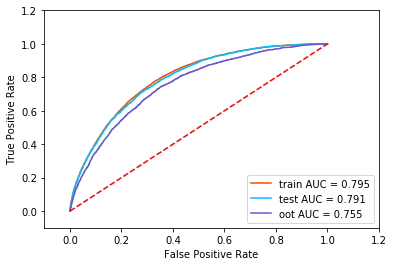

/data1/jupyterhub/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/data1/jupyterhub/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


ks_value is 0.4466 at pop = 0.4067


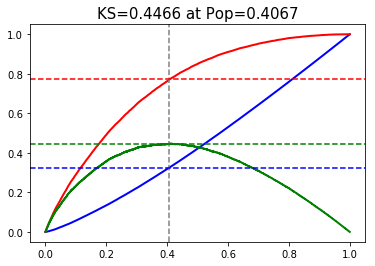

ks_value is 0.434 at pop = 0.371


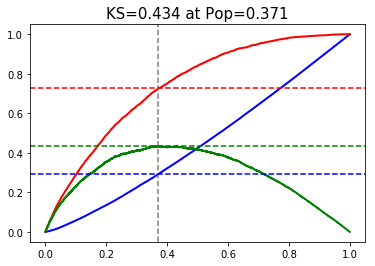

ks_value is 0.3905 at pop = 0.4324


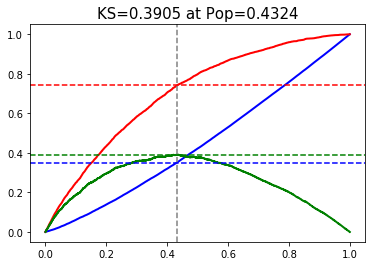

In [239]:
plt.plot(false_positive_rate_train, true_positive_rate_train, 'b',label='train AUC = %0.3f'% roc_auc_train,color='orangered')
plt.plot(false_positive_rate_test, true_positive_rate_test, 'b',label='test AUC = %0.3f'% roc_auc_test,color='deepskyblue')
plt.plot(false_positive_rate_oot, true_positive_rate_oot, 'b',label='oot AUC = %0.3f'% roc_auc_oot,color='slateblue')
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.1,1.2])
plt.ylim([-0.1,1.2])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()
PlotKS(dtrain_predprob, train_y, n=train_y.shape[0], asc=0)
PlotKS(dtest_predprob, test_y, n=test_y.shape[0], asc=0)
PlotKS(doot_predprob, test_y1['14d'], n=test_y1.shape[0], asc=0)

## catboost 和xgb数据源一致

### 载入包

In [2]:
import catboost as cb

### cb模型训练

In [241]:
train_pool=cb.Pool(train_x,train_y)
test_pool=cb.Pool(test_x,test_y)
model=cb.CatBoostClassifier(eval_metric='AUC')
model.fit(train_pool)

0:	learn: 0.7314154	total: 35.1ms	remaining: 35.1s
1:	learn: 0.7414308	total: 66.1ms	remaining: 33s
2:	learn: 0.7425383	total: 96.9ms	remaining: 32.2s
3:	learn: 0.7417831	total: 127ms	remaining: 31.6s
4:	learn: 0.7448985	total: 161ms	remaining: 32s
5:	learn: 0.7479101	total: 195ms	remaining: 32.3s
6:	learn: 0.7511016	total: 228ms	remaining: 32.3s
7:	learn: 0.7524970	total: 269ms	remaining: 33.3s
8:	learn: 0.7518627	total: 302ms	remaining: 33.3s
9:	learn: 0.7525017	total: 334ms	remaining: 33.1s
10:	learn: 0.7538832	total: 371ms	remaining: 33.4s
11:	learn: 0.7534159	total: 404ms	remaining: 33.3s
12:	learn: 0.7539893	total: 440ms	remaining: 33.4s
13:	learn: 0.7546087	total: 477ms	remaining: 33.6s
14:	learn: 0.7552026	total: 513ms	remaining: 33.7s
15:	learn: 0.7562104	total: 553ms	remaining: 34s
16:	learn: 0.7574706	total: 590ms	remaining: 34.1s
17:	learn: 0.7575271	total: 627ms	remaining: 34.2s
18:	learn: 0.7578760	total: 660ms	remaining: 34.1s
19:	learn: 0.7587187	total: 694ms	remaining:

161:	learn: 0.7917459	total: 5.87s	remaining: 30.4s
162:	learn: 0.7918719	total: 5.9s	remaining: 30.3s
163:	learn: 0.7919707	total: 5.94s	remaining: 30.3s
164:	learn: 0.7920764	total: 5.97s	remaining: 30.2s
165:	learn: 0.7921596	total: 6.01s	remaining: 30.2s
166:	learn: 0.7922342	total: 6.04s	remaining: 30.1s
167:	learn: 0.7923036	total: 6.08s	remaining: 30.1s
168:	learn: 0.7924459	total: 6.11s	remaining: 30s
169:	learn: 0.7925329	total: 6.14s	remaining: 30s
170:	learn: 0.7926431	total: 6.17s	remaining: 29.9s
171:	learn: 0.7927312	total: 6.21s	remaining: 29.9s
172:	learn: 0.7928319	total: 6.24s	remaining: 29.8s
173:	learn: 0.7929361	total: 6.27s	remaining: 29.8s
174:	learn: 0.7929980	total: 6.31s	remaining: 29.7s
175:	learn: 0.7930900	total: 6.35s	remaining: 29.7s
176:	learn: 0.7932270	total: 6.38s	remaining: 29.7s
177:	learn: 0.7933351	total: 6.42s	remaining: 29.6s
178:	learn: 0.7934942	total: 6.45s	remaining: 29.6s
179:	learn: 0.7935795	total: 6.49s	remaining: 29.6s
180:	learn: 0.793

323:	learn: 0.8038762	total: 11.7s	remaining: 24.5s
324:	learn: 0.8039147	total: 11.8s	remaining: 24.5s
325:	learn: 0.8039809	total: 11.8s	remaining: 24.4s
326:	learn: 0.8040146	total: 11.9s	remaining: 24.4s
327:	learn: 0.8040710	total: 11.9s	remaining: 24.4s
328:	learn: 0.8041168	total: 11.9s	remaining: 24.3s
329:	learn: 0.8041563	total: 12s	remaining: 24.3s
330:	learn: 0.8041876	total: 12s	remaining: 24.3s
331:	learn: 0.8042402	total: 12s	remaining: 24.2s
332:	learn: 0.8042677	total: 12.1s	remaining: 24.2s
333:	learn: 0.8043275	total: 12.1s	remaining: 24.2s
334:	learn: 0.8043594	total: 12.2s	remaining: 24.1s
335:	learn: 0.8044063	total: 12.2s	remaining: 24.1s
336:	learn: 0.8044416	total: 12.2s	remaining: 24.1s
337:	learn: 0.8045043	total: 12.3s	remaining: 24s
338:	learn: 0.8045656	total: 12.3s	remaining: 24s
339:	learn: 0.8046522	total: 12.3s	remaining: 23.9s
340:	learn: 0.8047192	total: 12.4s	remaining: 23.9s
341:	learn: 0.8047607	total: 12.4s	remaining: 23.9s
342:	learn: 0.8048107	

482:	learn: 0.8110608	total: 17.5s	remaining: 18.8s
483:	learn: 0.8111104	total: 17.6s	remaining: 18.8s
484:	learn: 0.8111561	total: 17.6s	remaining: 18.7s
485:	learn: 0.8112013	total: 17.7s	remaining: 18.7s
486:	learn: 0.8112436	total: 17.7s	remaining: 18.6s
487:	learn: 0.8112906	total: 17.7s	remaining: 18.6s
488:	learn: 0.8113425	total: 17.8s	remaining: 18.6s
489:	learn: 0.8113862	total: 17.8s	remaining: 18.5s
490:	learn: 0.8114244	total: 17.8s	remaining: 18.5s
491:	learn: 0.8114561	total: 17.9s	remaining: 18.4s
492:	learn: 0.8115169	total: 17.9s	remaining: 18.4s
493:	learn: 0.8115517	total: 17.9s	remaining: 18.4s
494:	learn: 0.8115858	total: 18s	remaining: 18.3s
495:	learn: 0.8116299	total: 18s	remaining: 18.3s
496:	learn: 0.8116941	total: 18s	remaining: 18.3s
497:	learn: 0.8117425	total: 18.1s	remaining: 18.2s
498:	learn: 0.8117826	total: 18.1s	remaining: 18.2s
499:	learn: 0.8118230	total: 18.1s	remaining: 18.1s
500:	learn: 0.8118596	total: 18.2s	remaining: 18.1s
501:	learn: 0.8119

641:	learn: 0.8170960	total: 23.3s	remaining: 13s
642:	learn: 0.8171378	total: 23.3s	remaining: 13s
643:	learn: 0.8171723	total: 23.4s	remaining: 12.9s
644:	learn: 0.8172174	total: 23.4s	remaining: 12.9s
645:	learn: 0.8172524	total: 23.4s	remaining: 12.8s
646:	learn: 0.8173125	total: 23.5s	remaining: 12.8s
647:	learn: 0.8173425	total: 23.5s	remaining: 12.8s
648:	learn: 0.8173559	total: 23.5s	remaining: 12.7s
649:	learn: 0.8173935	total: 23.6s	remaining: 12.7s
650:	learn: 0.8174390	total: 23.6s	remaining: 12.7s
651:	learn: 0.8174804	total: 23.6s	remaining: 12.6s
652:	learn: 0.8175505	total: 23.7s	remaining: 12.6s
653:	learn: 0.8175807	total: 23.7s	remaining: 12.5s
654:	learn: 0.8176261	total: 23.8s	remaining: 12.5s
655:	learn: 0.8176573	total: 23.8s	remaining: 12.5s
656:	learn: 0.8176723	total: 23.8s	remaining: 12.4s
657:	learn: 0.8177141	total: 23.9s	remaining: 12.4s
658:	learn: 0.8177490	total: 23.9s	remaining: 12.4s
659:	learn: 0.8177662	total: 23.9s	remaining: 12.3s
660:	learn: 0.81

802:	learn: 0.8228806	total: 29.1s	remaining: 7.13s
803:	learn: 0.8229252	total: 29.1s	remaining: 7.09s
804:	learn: 0.8229531	total: 29.1s	remaining: 7.06s
805:	learn: 0.8230075	total: 29.2s	remaining: 7.02s
806:	learn: 0.8230516	total: 29.2s	remaining: 6.99s
807:	learn: 0.8230821	total: 29.2s	remaining: 6.95s
808:	learn: 0.8231033	total: 29.3s	remaining: 6.92s
809:	learn: 0.8231413	total: 29.3s	remaining: 6.88s
810:	learn: 0.8231798	total: 29.4s	remaining: 6.84s
811:	learn: 0.8231915	total: 29.4s	remaining: 6.81s
812:	learn: 0.8232281	total: 29.5s	remaining: 6.77s
813:	learn: 0.8232866	total: 29.5s	remaining: 6.74s
814:	learn: 0.8233169	total: 29.5s	remaining: 6.7s
815:	learn: 0.8233424	total: 29.6s	remaining: 6.67s
816:	learn: 0.8233702	total: 29.6s	remaining: 6.63s
817:	learn: 0.8234103	total: 29.6s	remaining: 6.59s
818:	learn: 0.8234584	total: 29.7s	remaining: 6.56s
819:	learn: 0.8235078	total: 29.7s	remaining: 6.52s
820:	learn: 0.8235530	total: 29.7s	remaining: 6.48s
821:	learn: 0

965:	learn: 0.8282622	total: 35.1s	remaining: 1.23s
966:	learn: 0.8282925	total: 35.1s	remaining: 1.2s
967:	learn: 0.8283229	total: 35.1s	remaining: 1.16s
968:	learn: 0.8283474	total: 35.2s	remaining: 1.12s
969:	learn: 0.8283771	total: 35.2s	remaining: 1.09s
970:	learn: 0.8284235	total: 35.2s	remaining: 1.05s
971:	learn: 0.8284542	total: 35.3s	remaining: 1.01s
972:	learn: 0.8284966	total: 35.3s	remaining: 980ms
973:	learn: 0.8285145	total: 35.3s	remaining: 943ms
974:	learn: 0.8285460	total: 35.4s	remaining: 907ms
975:	learn: 0.8285857	total: 35.4s	remaining: 871ms
976:	learn: 0.8286184	total: 35.5s	remaining: 835ms
977:	learn: 0.8286451	total: 35.5s	remaining: 798ms
978:	learn: 0.8286713	total: 35.5s	remaining: 762ms
979:	learn: 0.8287150	total: 35.6s	remaining: 726ms
980:	learn: 0.8287429	total: 35.6s	remaining: 690ms
981:	learn: 0.8287774	total: 35.6s	remaining: 653ms
982:	learn: 0.8288147	total: 35.7s	remaining: 617ms
983:	learn: 0.8288423	total: 35.7s	remaining: 581ms
984:	learn: 0

### 模型预测

In [242]:
dtrain_predictions = model.predict(train_x)
dtrain_predprob = model.predict_proba(train_x)[:,1]
dtest_predictions = model.predict(test_x)
dtest_predprob = model.predict_proba(test_x)[:,1]

### 模型评价

In [243]:
#训练集模型评价
false_positive_rate_train, true_positive_rate_train, thresholds_train = roc_curve(train_y, dtrain_predprob ) 
roc_auc_train = auc(false_positive_rate_train, true_positive_rate_train)
ks_train = abs(false_positive_rate_train-true_positive_rate_train).max()
#预测集模型评价
false_positive_rate_test, true_positive_rate_test, thresholds_test = roc_curve(test_y, dtest_predprob ) 
roc_auc_test = auc(false_positive_rate_test, true_positive_rate_test)
# plt.plot(false_positive_rate, true_positive_rate, 'b',
# label='AUC = %0.2f'% roc_auc)
# plt.legend(loc='lower right')
# plt.plot([0,1],[0,1],'r--')
# plt.xlim([-0.1,1.2])
# plt.ylim([-0.1,1.2])
# plt.ylabel('True Positive Rate')
# plt.xlabel('False Positive Rate')
# plt.show()
ks_test = abs(false_positive_rate_test-true_positive_rate_test).max()

### OOT

In [244]:
bst1=cb.CatBoostClassifier()
bst1.fit(train,train_y1)
doot_predictions = bst1.predict(test)
doot_predprob = bst1.predict_proba(test)[:,1]
false_positive_rate_oot, true_positive_rate_oot, thresholds_oot = roc_curve(test_y1, doot_predprob ) 
roc_auc_oot = auc(false_positive_rate_oot, true_positive_rate_oot)
ks_oot = abs(false_positive_rate_oot-true_positive_rate_oot).max()

0:	learn: 0.6716990	total: 17.8ms	remaining: 17.8s
1:	learn: 0.6524072	total: 38.5ms	remaining: 19.2s
2:	learn: 0.6347233	total: 56.6ms	remaining: 18.8s
3:	learn: 0.6178236	total: 73.7ms	remaining: 18.3s
4:	learn: 0.6027441	total: 90.7ms	remaining: 18.1s
5:	learn: 0.5884830	total: 106ms	remaining: 17.6s
6:	learn: 0.5755257	total: 122ms	remaining: 17.3s
7:	learn: 0.5634186	total: 140ms	remaining: 17.4s
8:	learn: 0.5526160	total: 162ms	remaining: 17.8s
9:	learn: 0.5422186	total: 181ms	remaining: 17.9s
10:	learn: 0.5321409	total: 196ms	remaining: 17.6s
11:	learn: 0.5233346	total: 211ms	remaining: 17.3s
12:	learn: 0.5157067	total: 230ms	remaining: 17.4s
13:	learn: 0.5084481	total: 249ms	remaining: 17.5s
14:	learn: 0.5007538	total: 264ms	remaining: 17.3s
15:	learn: 0.4941459	total: 279ms	remaining: 17.2s
16:	learn: 0.4879056	total: 297ms	remaining: 17.2s
17:	learn: 0.4825126	total: 311ms	remaining: 16.9s
18:	learn: 0.4776070	total: 325ms	remaining: 16.8s
19:	learn: 0.4728307	total: 338ms	re

172:	learn: 0.3791675	total: 2.67s	remaining: 12.8s
173:	learn: 0.3790188	total: 2.68s	remaining: 12.7s
174:	learn: 0.3789377	total: 2.7s	remaining: 12.7s
175:	learn: 0.3788568	total: 2.71s	remaining: 12.7s
176:	learn: 0.3787614	total: 2.72s	remaining: 12.7s
177:	learn: 0.3787065	total: 2.74s	remaining: 12.7s
178:	learn: 0.3786237	total: 2.75s	remaining: 12.6s
179:	learn: 0.3785603	total: 2.77s	remaining: 12.6s
180:	learn: 0.3785118	total: 2.78s	remaining: 12.6s
181:	learn: 0.3784267	total: 2.79s	remaining: 12.5s
182:	learn: 0.3783320	total: 2.81s	remaining: 12.5s
183:	learn: 0.3782564	total: 2.82s	remaining: 12.5s
184:	learn: 0.3781522	total: 2.83s	remaining: 12.5s
185:	learn: 0.3781080	total: 2.85s	remaining: 12.5s
186:	learn: 0.3780329	total: 2.86s	remaining: 12.4s
187:	learn: 0.3779173	total: 2.87s	remaining: 12.4s
188:	learn: 0.3778478	total: 2.89s	remaining: 12.4s
189:	learn: 0.3777902	total: 2.9s	remaining: 12.4s
190:	learn: 0.3777270	total: 2.92s	remaining: 12.4s
191:	learn: 0.

339:	learn: 0.3696053	total: 5.11s	remaining: 9.91s
340:	learn: 0.3695594	total: 5.12s	remaining: 9.9s
341:	learn: 0.3695292	total: 5.14s	remaining: 9.89s
342:	learn: 0.3694902	total: 5.15s	remaining: 9.87s
343:	learn: 0.3694644	total: 5.17s	remaining: 9.85s
344:	learn: 0.3694383	total: 5.18s	remaining: 9.83s
345:	learn: 0.3694071	total: 5.19s	remaining: 9.82s
346:	learn: 0.3693666	total: 5.21s	remaining: 9.81s
347:	learn: 0.3693231	total: 5.22s	remaining: 9.79s
348:	learn: 0.3693080	total: 5.24s	remaining: 9.77s
349:	learn: 0.3692645	total: 5.26s	remaining: 9.77s
350:	learn: 0.3692392	total: 5.28s	remaining: 9.76s
351:	learn: 0.3691957	total: 5.29s	remaining: 9.74s
352:	learn: 0.3691586	total: 5.31s	remaining: 9.74s
353:	learn: 0.3691017	total: 5.33s	remaining: 9.73s
354:	learn: 0.3690678	total: 5.34s	remaining: 9.71s
355:	learn: 0.3690328	total: 5.36s	remaining: 9.69s
356:	learn: 0.3689941	total: 5.37s	remaining: 9.68s
357:	learn: 0.3689715	total: 5.38s	remaining: 9.66s
358:	learn: 0

511:	learn: 0.3636907	total: 7.56s	remaining: 7.21s
512:	learn: 0.3636646	total: 7.58s	remaining: 7.19s
513:	learn: 0.3636433	total: 7.59s	remaining: 7.17s
514:	learn: 0.3636204	total: 7.6s	remaining: 7.16s
515:	learn: 0.3635849	total: 7.61s	remaining: 7.14s
516:	learn: 0.3635338	total: 7.63s	remaining: 7.13s
517:	learn: 0.3635009	total: 7.64s	remaining: 7.11s
518:	learn: 0.3634892	total: 7.65s	remaining: 7.09s
519:	learn: 0.3634586	total: 7.67s	remaining: 7.08s
520:	learn: 0.3634385	total: 7.68s	remaining: 7.06s
521:	learn: 0.3633912	total: 7.69s	remaining: 7.04s
522:	learn: 0.3633598	total: 7.7s	remaining: 7.03s
523:	learn: 0.3633349	total: 7.71s	remaining: 7.01s
524:	learn: 0.3632964	total: 7.73s	remaining: 6.99s
525:	learn: 0.3632458	total: 7.74s	remaining: 6.97s
526:	learn: 0.3632083	total: 7.75s	remaining: 6.96s
527:	learn: 0.3631854	total: 7.76s	remaining: 6.94s
528:	learn: 0.3631575	total: 7.78s	remaining: 6.92s
529:	learn: 0.3631232	total: 7.79s	remaining: 6.91s
530:	learn: 0.

679:	learn: 0.3589876	total: 10s	remaining: 4.71s
680:	learn: 0.3589606	total: 10s	remaining: 4.7s
681:	learn: 0.3589290	total: 10s	remaining: 4.68s
682:	learn: 0.3589117	total: 10.1s	remaining: 4.66s
683:	learn: 0.3588701	total: 10.1s	remaining: 4.65s
684:	learn: 0.3588332	total: 10.1s	remaining: 4.63s
685:	learn: 0.3588041	total: 10.1s	remaining: 4.62s
686:	learn: 0.3587915	total: 10.1s	remaining: 4.6s
687:	learn: 0.3587601	total: 10.1s	remaining: 4.59s
688:	learn: 0.3587413	total: 10.1s	remaining: 4.57s
689:	learn: 0.3587274	total: 10.1s	remaining: 4.55s
690:	learn: 0.3587055	total: 10.2s	remaining: 4.54s
691:	learn: 0.3586846	total: 10.2s	remaining: 4.52s
692:	learn: 0.3586572	total: 10.2s	remaining: 4.51s
693:	learn: 0.3586236	total: 10.2s	remaining: 4.49s
694:	learn: 0.3586082	total: 10.2s	remaining: 4.48s
695:	learn: 0.3585943	total: 10.2s	remaining: 4.46s
696:	learn: 0.3585508	total: 10.2s	remaining: 4.45s
697:	learn: 0.3585225	total: 10.2s	remaining: 4.43s
698:	learn: 0.358507

843:	learn: 0.3546208	total: 12.5s	remaining: 2.31s
844:	learn: 0.3545996	total: 12.5s	remaining: 2.29s
845:	learn: 0.3545653	total: 12.5s	remaining: 2.28s
846:	learn: 0.3545469	total: 12.5s	remaining: 2.26s
847:	learn: 0.3545273	total: 12.5s	remaining: 2.25s
848:	learn: 0.3545069	total: 12.6s	remaining: 2.23s
849:	learn: 0.3544729	total: 12.6s	remaining: 2.22s
850:	learn: 0.3544610	total: 12.6s	remaining: 2.2s
851:	learn: 0.3544447	total: 12.6s	remaining: 2.19s
852:	learn: 0.3544142	total: 12.6s	remaining: 2.17s
853:	learn: 0.3543859	total: 12.6s	remaining: 2.16s
854:	learn: 0.3543681	total: 12.6s	remaining: 2.15s
855:	learn: 0.3543538	total: 12.7s	remaining: 2.13s
856:	learn: 0.3543321	total: 12.7s	remaining: 2.12s
857:	learn: 0.3542950	total: 12.7s	remaining: 2.1s
858:	learn: 0.3542747	total: 12.7s	remaining: 2.09s
859:	learn: 0.3542473	total: 12.7s	remaining: 2.08s
860:	learn: 0.3542177	total: 12.8s	remaining: 2.06s
861:	learn: 0.3541876	total: 12.8s	remaining: 2.05s
862:	learn: 0.

### train、test、oot的auc、ks比较

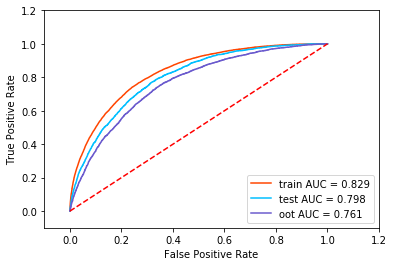

/data1/jupyterhub/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/data1/jupyterhub/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


ks_value is 0.5 at pop = 0.3579


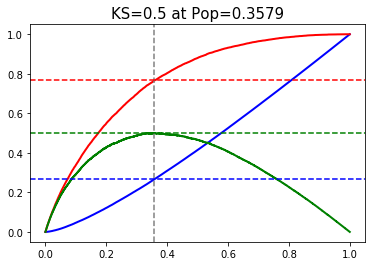

ks_value is 0.4527 at pop = 0.4022


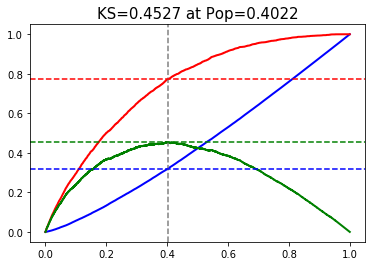

ks_value is 0.4027 at pop = 0.4452


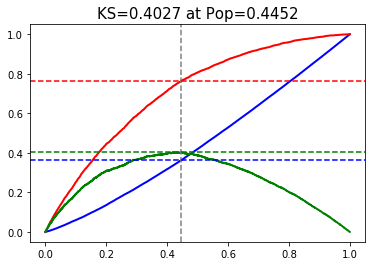

In [245]:
plt.plot(false_positive_rate_train, true_positive_rate_train, 'b',label='train AUC = %0.3f'% roc_auc_train,color='orangered')
plt.plot(false_positive_rate_test, true_positive_rate_test, 'b',label='test AUC = %0.3f'% roc_auc_test,color='deepskyblue')
plt.plot(false_positive_rate_oot, true_positive_rate_oot, 'b',label='oot AUC = %0.3f'% roc_auc_oot,color='slateblue')
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.1,1.2])
plt.ylim([-0.1,1.2])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()
PlotKS(dtrain_predprob, train_y, n=train_y.shape[0], asc=0)
PlotKS(dtest_predprob, test_y, n=test_y.shape[0], asc=0)
PlotKS(doot_predprob, test_y1['14d'], n=test_y1.shape[0], asc=0)

## catboost 加入字符型变量

### 数据载入

In [246]:
fea_in = ['account_reg_time', 'age', 'consumer_label_if_pay_ins', 'individual_gender', 'jd_score', 'kx_score', 'phone_reg_time', 'channel_name_1', 'r_woe_prea_v5_fico', 'province', 'r_woe_xy_score', 'td_count_7d', 'user_gray_contacts_gray_score_be_mean', 'user_gray_contacts_gray_score_to_min', 'user_gray_contacts_number_statistic_cnt_be_all', 'user_gray_contacts_number_statistic_cnt_to_applied', 'user_gray_contacts_number_statistic_pct_cnt_be_all', 'user_gray_contacts_number_statistic_pct_cnt_to_applied', 'user_gray_contacts_query_to_query_cnt_12', 'user_gray_contacts_query_to_query_cnt_6', 'user_gray_contacts_rfm_call_cnt_be_all', 'user_gray_phone_gray_score', 'user_gray_weight_all', 'user_gray_weight_to_all', 'user_searched_history_by_day_d_15_cnt_org', 'user_searched_history_by_day_d_7_cnt', 'user_searched_history_by_day_d_7_cnt_cash', 'user_searched_history_by_day_d_7_pct_cnt_all', 'user_searched_history_by_day_m_24_cnt', 'user_searched_history_by_day_m_24_cnt_cash', 'user_searched_history_by_day_m_24_cnt_org_cf']
feature1=df[fea_in]
feature1['kx_score']=pd.qcut(feature1['kx_score'],10,labels=False)+1
label1=df['14d']
feature1['channel_name_1'].fillna('',inplace=True)
#c = a if a>b else b
#feature2['channel_name_1']=feature2['channel_name_1'] if feature2['channel_name_1'].notnull()==True else a

/data1/jupyterhub/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/data1/jupyterhub/anaconda3/lib/python3.6/site-packages/pandas/core/generic.py:3549: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)


### 训练集、测试集划分

In [247]:
train_x, test_x, train_y, test_y = train_test_split(feature1, label1, random_state=0, test_size = 0.2)
#index=np.where(train['channel_name_1'].notnull()==False)

### 模型训练

In [248]:
cat_features_index=[7,9]
model=cb.CatBoostClassifier(eval_metric='AUC')
model.fit(train_x,train_y,cat_features=cat_features_index)

0:	learn: 0.7310767	total: 42.5ms	remaining: 42.4s
1:	learn: 0.7395911	total: 87.6ms	remaining: 43.7s
2:	learn: 0.7443355	total: 135ms	remaining: 44.7s
3:	learn: 0.7448056	total: 182ms	remaining: 45.3s
4:	learn: 0.7455196	total: 227ms	remaining: 45.2s
5:	learn: 0.7470881	total: 269ms	remaining: 44.5s
6:	learn: 0.7488364	total: 318ms	remaining: 45.1s
7:	learn: 0.7494611	total: 364ms	remaining: 45.2s
8:	learn: 0.7500741	total: 411ms	remaining: 45.3s
9:	learn: 0.7504000	total: 459ms	remaining: 45.4s
10:	learn: 0.7511825	total: 508ms	remaining: 45.7s
11:	learn: 0.7515500	total: 561ms	remaining: 46.2s
12:	learn: 0.7526857	total: 609ms	remaining: 46.3s
13:	learn: 0.7534644	total: 661ms	remaining: 46.5s
14:	learn: 0.7535744	total: 712ms	remaining: 46.7s
15:	learn: 0.7540506	total: 769ms	remaining: 47.3s
16:	learn: 0.7543922	total: 822ms	remaining: 47.5s
17:	learn: 0.7556017	total: 874ms	remaining: 47.7s
18:	learn: 0.7566367	total: 921ms	remaining: 47.5s
19:	learn: 0.7571929	total: 970ms	remai

161:	learn: 0.7903609	total: 8.34s	remaining: 43.2s
162:	learn: 0.7904979	total: 8.39s	remaining: 43.1s
163:	learn: 0.7905880	total: 8.44s	remaining: 43s
164:	learn: 0.7907174	total: 8.5s	remaining: 43s
165:	learn: 0.7908191	total: 8.55s	remaining: 43s
166:	learn: 0.7909129	total: 8.61s	remaining: 42.9s
167:	learn: 0.7909906	total: 8.65s	remaining: 42.9s
168:	learn: 0.7911443	total: 8.7s	remaining: 42.8s
169:	learn: 0.7912368	total: 8.75s	remaining: 42.7s
170:	learn: 0.7913475	total: 8.8s	remaining: 42.7s
171:	learn: 0.7914192	total: 8.85s	remaining: 42.6s
172:	learn: 0.7915004	total: 8.91s	remaining: 42.6s
173:	learn: 0.7915908	total: 8.96s	remaining: 42.5s
174:	learn: 0.7917099	total: 9.01s	remaining: 42.5s
175:	learn: 0.7917562	total: 9.05s	remaining: 42.4s
176:	learn: 0.7918753	total: 9.1s	remaining: 42.3s
177:	learn: 0.7919595	total: 9.15s	remaining: 42.3s
178:	learn: 0.7920591	total: 9.21s	remaining: 42.2s
179:	learn: 0.7921832	total: 9.26s	remaining: 42.2s
180:	learn: 0.7922839	

320:	learn: 0.8018319	total: 16.5s	remaining: 34.9s
321:	learn: 0.8018742	total: 16.5s	remaining: 34.8s
322:	learn: 0.8018972	total: 16.6s	remaining: 34.8s
323:	learn: 0.8019447	total: 16.6s	remaining: 34.7s
324:	learn: 0.8020219	total: 16.7s	remaining: 34.7s
325:	learn: 0.8020759	total: 16.7s	remaining: 34.6s
326:	learn: 0.8021324	total: 16.8s	remaining: 34.6s
327:	learn: 0.8021847	total: 16.9s	remaining: 34.5s
328:	learn: 0.8022505	total: 16.9s	remaining: 34.5s
329:	learn: 0.8023101	total: 17s	remaining: 34.4s
330:	learn: 0.8023634	total: 17s	remaining: 34.3s
331:	learn: 0.8023913	total: 17s	remaining: 34.3s
332:	learn: 0.8024474	total: 17.1s	remaining: 34.2s
333:	learn: 0.8025155	total: 17.1s	remaining: 34.2s
334:	learn: 0.8025581	total: 17.2s	remaining: 34.1s
335:	learn: 0.8026198	total: 17.2s	remaining: 34.1s
336:	learn: 0.8026689	total: 17.3s	remaining: 34s
337:	learn: 0.8027292	total: 17.3s	remaining: 33.9s
338:	learn: 0.8028031	total: 17.4s	remaining: 33.9s
339:	learn: 0.802861

480:	learn: 0.8090280	total: 24.6s	remaining: 26.5s
481:	learn: 0.8090873	total: 24.6s	remaining: 26.5s
482:	learn: 0.8090968	total: 24.7s	remaining: 26.4s
483:	learn: 0.8091578	total: 24.7s	remaining: 26.4s
484:	learn: 0.8092086	total: 24.8s	remaining: 26.3s
485:	learn: 0.8092753	total: 24.8s	remaining: 26.3s
486:	learn: 0.8093088	total: 24.9s	remaining: 26.2s
487:	learn: 0.8093539	total: 24.9s	remaining: 26.1s
488:	learn: 0.8094023	total: 25s	remaining: 26.1s
489:	learn: 0.8094443	total: 25s	remaining: 26s
490:	learn: 0.8094943	total: 25.1s	remaining: 26s
491:	learn: 0.8095164	total: 25.1s	remaining: 25.9s
492:	learn: 0.8095648	total: 25.2s	remaining: 25.9s
493:	learn: 0.8096196	total: 25.2s	remaining: 25.8s
494:	learn: 0.8096633	total: 25.3s	remaining: 25.8s
495:	learn: 0.8096973	total: 25.3s	remaining: 25.7s
496:	learn: 0.8097267	total: 25.4s	remaining: 25.7s
497:	learn: 0.8097479	total: 25.4s	remaining: 25.7s
498:	learn: 0.8097800	total: 25.5s	remaining: 25.6s
499:	learn: 0.809802

642:	learn: 0.8152331	total: 32.8s	remaining: 18.2s
643:	learn: 0.8152863	total: 32.8s	remaining: 18.2s
644:	learn: 0.8153339	total: 32.9s	remaining: 18.1s
645:	learn: 0.8153932	total: 32.9s	remaining: 18.1s
646:	learn: 0.8154309	total: 33s	remaining: 18s
647:	learn: 0.8154706	total: 33.1s	remaining: 18s
648:	learn: 0.8155190	total: 33.1s	remaining: 17.9s
649:	learn: 0.8155630	total: 33.1s	remaining: 17.8s
650:	learn: 0.8156250	total: 33.2s	remaining: 17.8s
651:	learn: 0.8156594	total: 33.3s	remaining: 17.7s
652:	learn: 0.8156797	total: 33.3s	remaining: 17.7s
653:	learn: 0.8157069	total: 33.3s	remaining: 17.6s
654:	learn: 0.8157521	total: 33.4s	remaining: 17.6s
655:	learn: 0.8158055	total: 33.4s	remaining: 17.5s
656:	learn: 0.8158402	total: 33.5s	remaining: 17.5s
657:	learn: 0.8158832	total: 33.5s	remaining: 17.4s
658:	learn: 0.8159306	total: 33.6s	remaining: 17.4s
659:	learn: 0.8159679	total: 33.6s	remaining: 17.3s
660:	learn: 0.8160073	total: 33.7s	remaining: 17.3s
661:	learn: 0.8160

803:	learn: 0.8209285	total: 41s	remaining: 9.99s
804:	learn: 0.8209706	total: 41s	remaining: 9.94s
805:	learn: 0.8210247	total: 41.1s	remaining: 9.89s
806:	learn: 0.8210570	total: 41.1s	remaining: 9.84s
807:	learn: 0.8210965	total: 41.2s	remaining: 9.79s
808:	learn: 0.8211158	total: 41.2s	remaining: 9.73s
809:	learn: 0.8211407	total: 41.3s	remaining: 9.68s
810:	learn: 0.8211905	total: 41.3s	remaining: 9.63s
811:	learn: 0.8212161	total: 41.4s	remaining: 9.58s
812:	learn: 0.8212478	total: 41.4s	remaining: 9.53s
813:	learn: 0.8212668	total: 41.5s	remaining: 9.48s
814:	learn: 0.8213077	total: 41.5s	remaining: 9.43s
815:	learn: 0.8213305	total: 41.6s	remaining: 9.38s
816:	learn: 0.8213559	total: 41.6s	remaining: 9.32s
817:	learn: 0.8213664	total: 41.7s	remaining: 9.27s
818:	learn: 0.8214050	total: 41.7s	remaining: 9.22s
819:	learn: 0.8214424	total: 41.8s	remaining: 9.17s
820:	learn: 0.8214674	total: 41.8s	remaining: 9.12s
821:	learn: 0.8214987	total: 41.9s	remaining: 9.06s
822:	learn: 0.82

965:	learn: 0.8260672	total: 49s	remaining: 1.73s
966:	learn: 0.8260840	total: 49.1s	remaining: 1.67s
967:	learn: 0.8261483	total: 49.1s	remaining: 1.62s
968:	learn: 0.8261837	total: 49.2s	remaining: 1.57s
969:	learn: 0.8262166	total: 49.2s	remaining: 1.52s
970:	learn: 0.8262414	total: 49.3s	remaining: 1.47s
971:	learn: 0.8262676	total: 49.3s	remaining: 1.42s
972:	learn: 0.8263054	total: 49.4s	remaining: 1.37s
973:	learn: 0.8263415	total: 49.4s	remaining: 1.32s
974:	learn: 0.8263834	total: 49.5s	remaining: 1.27s
975:	learn: 0.8263915	total: 49.5s	remaining: 1.22s
976:	learn: 0.8264083	total: 49.5s	remaining: 1.17s
977:	learn: 0.8264579	total: 49.6s	remaining: 1.11s
978:	learn: 0.8265057	total: 49.6s	remaining: 1.06s
979:	learn: 0.8265559	total: 49.7s	remaining: 1.01s
980:	learn: 0.8265909	total: 49.7s	remaining: 963ms
981:	learn: 0.8266322	total: 49.8s	remaining: 913ms
982:	learn: 0.8266636	total: 49.8s	remaining: 862ms
983:	learn: 0.8266986	total: 49.9s	remaining: 811ms
984:	learn: 0.

### 模型预测

In [249]:
dtrain_predictions1 = model.predict(train_x)
dtrain_predprob1 = model.predict_proba(train_x)[:,1]
dtest_predictions2 = model.predict(test_x)
dtest_predprob2 = model.predict_proba(test_x)[:,1]

### 模型评价

In [250]:
false_positive_rate1, true_positive_rate1, thresholds1 = roc_curve(train_y, dtrain_predprob1 ) 
false_positive_rate2, true_positive_rate2, thresholds2 = roc_curve(test_y, dtest_predprob2) 
roc_auc1 = auc(false_positive_rate1, true_positive_rate1)
roc_auc2 = auc(false_positive_rate2, true_positive_rate2)

### OOT

In [251]:
fea_in = ['model_ind','account_reg_time', 'age', 'consumer_label_if_pay_ins', 'individual_gender', 'jd_score', 'kx_score', 'phone_reg_time', 'channel_name_1', 'r_woe_prea_v5_fico', 'province', 'r_woe_xy_score', 'td_count_7d', 'user_gray_contacts_gray_score_be_mean', 'user_gray_contacts_gray_score_to_min', 'user_gray_contacts_number_statistic_cnt_be_all', 'user_gray_contacts_number_statistic_cnt_to_applied', 'user_gray_contacts_number_statistic_pct_cnt_be_all', 'user_gray_contacts_number_statistic_pct_cnt_to_applied', 'user_gray_contacts_query_to_query_cnt_12', 'user_gray_contacts_query_to_query_cnt_6', 'user_gray_contacts_rfm_call_cnt_be_all', 'user_gray_phone_gray_score', 'user_gray_weight_all', 'user_gray_weight_to_all', 'user_searched_history_by_day_d_15_cnt_org', 'user_searched_history_by_day_d_7_cnt', 'user_searched_history_by_day_d_7_cnt_cash', 'user_searched_history_by_day_d_7_pct_cnt_all', 'user_searched_history_by_day_m_24_cnt', 'user_searched_history_by_day_m_24_cnt_cash', 'user_searched_history_by_day_m_24_cnt_org_cf']
feature2=df[fea_in]
feature2['kx_score']=pd.qcut(feature2['kx_score'],10,labels=False)+1
label2=df[['model_ind','14d']]
feature2['channel_name_1'].fillna('',inplace=True)
train=feature2[feature2['model_ind']!='O']
test=feature2[feature2['model_ind']=='O']
train=train.drop(['model_ind'],axis=1)
test=test.drop(['model_ind'],axis=1)
train_y2=label2[label2['model_ind']!='O']
test_y2=label2[label2['model_ind']=='O']
train_y2=train_y2.drop(['model_ind'],axis=1)
test_y2=test_y2.drop(['model_ind'],axis=1)
cat_features_index=[7,9]
model1=cb.CatBoostClassifier(eval_metric='AUC')
model1.fit(train,train_y2,cat_features=cat_features_index)
dtest_predictions3 = model1.predict(test)
dtest_predprob3 = model1.predict_proba(test)[:,1]
false_positive_rate3, true_positive_rate3, thresholds3 = roc_curve(test_y2, dtest_predprob3 )
roc_auc3 = auc(false_positive_rate3, true_positive_rate3)

/data1/jupyterhub/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/data1/jupyterhub/anaconda3/lib/python3.6/site-packages/pandas/core/generic.py:3549: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)


0:	learn: 0.7382723	total: 51.3ms	remaining: 51.2s
1:	learn: 0.7502543	total: 96.8ms	remaining: 48.3s
2:	learn: 0.7560039	total: 138ms	remaining: 45.7s
3:	learn: 0.7562030	total: 175ms	remaining: 43.6s
4:	learn: 0.7561978	total: 224ms	remaining: 44.5s
5:	learn: 0.7572449	total: 263ms	remaining: 43.6s
6:	learn: 0.7585187	total: 300ms	remaining: 42.5s
7:	learn: 0.7594842	total: 344ms	remaining: 42.6s
8:	learn: 0.7599935	total: 391ms	remaining: 43.1s
9:	learn: 0.7599380	total: 441ms	remaining: 43.7s
10:	learn: 0.7608765	total: 488ms	remaining: 43.9s
11:	learn: 0.7618050	total: 542ms	remaining: 44.6s
12:	learn: 0.7614752	total: 591ms	remaining: 44.8s
13:	learn: 0.7617990	total: 641ms	remaining: 45.1s
14:	learn: 0.7621370	total: 693ms	remaining: 45.5s
15:	learn: 0.7625235	total: 742ms	remaining: 45.7s
16:	learn: 0.7630167	total: 804ms	remaining: 46.5s
17:	learn: 0.7628000	total: 853ms	remaining: 46.6s
18:	learn: 0.7637428	total: 898ms	remaining: 46.4s
19:	learn: 0.7645667	total: 950ms	remai

163:	learn: 0.7999159	total: 8.17s	remaining: 41.7s
164:	learn: 0.8000307	total: 8.22s	remaining: 41.6s
165:	learn: 0.8001095	total: 8.27s	remaining: 41.6s
166:	learn: 0.8002067	total: 8.32s	remaining: 41.5s
167:	learn: 0.8003122	total: 8.36s	remaining: 41.4s
168:	learn: 0.8004529	total: 8.41s	remaining: 41.4s
169:	learn: 0.8005531	total: 8.46s	remaining: 41.3s
170:	learn: 0.8006660	total: 8.51s	remaining: 41.3s
171:	learn: 0.8007373	total: 8.57s	remaining: 41.3s
172:	learn: 0.8008500	total: 8.62s	remaining: 41.2s
173:	learn: 0.8009846	total: 8.68s	remaining: 41.2s
174:	learn: 0.8011268	total: 8.72s	remaining: 41.1s
175:	learn: 0.8012009	total: 8.79s	remaining: 41.1s
176:	learn: 0.8012708	total: 8.85s	remaining: 41.1s
177:	learn: 0.8013426	total: 8.9s	remaining: 41.1s
178:	learn: 0.8014264	total: 8.96s	remaining: 41.1s
179:	learn: 0.8015025	total: 9.01s	remaining: 41.1s
180:	learn: 0.8015492	total: 9.06s	remaining: 41s
181:	learn: 0.8016763	total: 9.11s	remaining: 40.9s
182:	learn: 0.8

325:	learn: 0.8112050	total: 16.2s	remaining: 33.5s
326:	learn: 0.8112629	total: 16.3s	remaining: 33.4s
327:	learn: 0.8113437	total: 16.3s	remaining: 33.4s
328:	learn: 0.8114067	total: 16.3s	remaining: 33.3s
329:	learn: 0.8114490	total: 16.4s	remaining: 33.3s
330:	learn: 0.8114976	total: 16.4s	remaining: 33.2s
331:	learn: 0.8115509	total: 16.5s	remaining: 33.2s
332:	learn: 0.8116017	total: 16.5s	remaining: 33.1s
333:	learn: 0.8116364	total: 16.6s	remaining: 33.1s
334:	learn: 0.8117020	total: 16.7s	remaining: 33.1s
335:	learn: 0.8117677	total: 16.7s	remaining: 33s
336:	learn: 0.8118295	total: 16.8s	remaining: 33s
337:	learn: 0.8118609	total: 16.8s	remaining: 32.9s
338:	learn: 0.8118973	total: 16.9s	remaining: 32.9s
339:	learn: 0.8119408	total: 16.9s	remaining: 32.8s
340:	learn: 0.8120029	total: 17s	remaining: 32.8s
341:	learn: 0.8120538	total: 17s	remaining: 32.7s
342:	learn: 0.8121314	total: 17s	remaining: 32.6s
343:	learn: 0.8121610	total: 17.1s	remaining: 32.6s
344:	learn: 0.8122077	

485:	learn: 0.8179711	total: 24s	remaining: 25.3s
486:	learn: 0.8180013	total: 24s	remaining: 25.3s
487:	learn: 0.8180485	total: 24.1s	remaining: 25.3s
488:	learn: 0.8181017	total: 24.1s	remaining: 25.2s
489:	learn: 0.8181228	total: 24.2s	remaining: 25.2s
490:	learn: 0.8181510	total: 24.2s	remaining: 25.1s
491:	learn: 0.8181799	total: 24.3s	remaining: 25s
492:	learn: 0.8182233	total: 24.3s	remaining: 25s
493:	learn: 0.8182423	total: 24.3s	remaining: 24.9s
494:	learn: 0.8182556	total: 24.4s	remaining: 24.9s
495:	learn: 0.8182876	total: 24.4s	remaining: 24.8s
496:	learn: 0.8183322	total: 24.5s	remaining: 24.8s
497:	learn: 0.8183644	total: 24.5s	remaining: 24.7s
498:	learn: 0.8183956	total: 24.6s	remaining: 24.7s
499:	learn: 0.8184356	total: 24.6s	remaining: 24.6s
500:	learn: 0.8184593	total: 24.7s	remaining: 24.6s
501:	learn: 0.8184827	total: 24.7s	remaining: 24.5s
502:	learn: 0.8185356	total: 24.8s	remaining: 24.5s
503:	learn: 0.8185586	total: 24.8s	remaining: 24.4s
504:	learn: 0.818591

648:	learn: 0.8238667	total: 31.8s	remaining: 17.2s
649:	learn: 0.8238906	total: 31.9s	remaining: 17.2s
650:	learn: 0.8239249	total: 31.9s	remaining: 17.1s
651:	learn: 0.8239406	total: 32s	remaining: 17.1s
652:	learn: 0.8239776	total: 32s	remaining: 17s
653:	learn: 0.8240185	total: 32s	remaining: 17s
654:	learn: 0.8240582	total: 32.1s	remaining: 16.9s
655:	learn: 0.8241082	total: 32.1s	remaining: 16.9s
656:	learn: 0.8241427	total: 32.2s	remaining: 16.8s
657:	learn: 0.8241755	total: 32.2s	remaining: 16.8s
658:	learn: 0.8242174	total: 32.3s	remaining: 16.7s
659:	learn: 0.8242427	total: 32.3s	remaining: 16.6s
660:	learn: 0.8242510	total: 32.4s	remaining: 16.6s
661:	learn: 0.8242714	total: 32.4s	remaining: 16.6s
662:	learn: 0.8242997	total: 32.5s	remaining: 16.5s
663:	learn: 0.8243488	total: 32.5s	remaining: 16.5s
664:	learn: 0.8243780	total: 32.6s	remaining: 16.4s
665:	learn: 0.8244243	total: 32.6s	remaining: 16.4s
666:	learn: 0.8244601	total: 32.7s	remaining: 16.3s
667:	learn: 0.8244913	

807:	learn: 0.8293995	total: 39.4s	remaining: 9.35s
808:	learn: 0.8294376	total: 39.4s	remaining: 9.3s
809:	learn: 0.8294460	total: 39.5s	remaining: 9.25s
810:	learn: 0.8294718	total: 39.5s	remaining: 9.21s
811:	learn: 0.8294903	total: 39.6s	remaining: 9.16s
812:	learn: 0.8295096	total: 39.6s	remaining: 9.11s
813:	learn: 0.8295522	total: 39.7s	remaining: 9.06s
814:	learn: 0.8295734	total: 39.7s	remaining: 9.01s
815:	learn: 0.8295973	total: 39.7s	remaining: 8.96s
816:	learn: 0.8296334	total: 39.8s	remaining: 8.91s
817:	learn: 0.8296773	total: 39.8s	remaining: 8.87s
818:	learn: 0.8297042	total: 39.9s	remaining: 8.82s
819:	learn: 0.8297235	total: 39.9s	remaining: 8.77s
820:	learn: 0.8297394	total: 40s	remaining: 8.72s
821:	learn: 0.8297828	total: 40s	remaining: 8.67s
822:	learn: 0.8298121	total: 40.1s	remaining: 8.62s
823:	learn: 0.8298545	total: 40.1s	remaining: 8.57s
824:	learn: 0.8298967	total: 40.2s	remaining: 8.52s
825:	learn: 0.8299274	total: 40.2s	remaining: 8.47s
826:	learn: 0.829

969:	learn: 0.8344403	total: 47.3s	remaining: 1.46s
970:	learn: 0.8344512	total: 47.3s	remaining: 1.41s
971:	learn: 0.8344848	total: 47.4s	remaining: 1.36s
972:	learn: 0.8345187	total: 47.4s	remaining: 1.32s
973:	learn: 0.8345406	total: 47.5s	remaining: 1.27s
974:	learn: 0.8345817	total: 47.5s	remaining: 1.22s
975:	learn: 0.8346230	total: 47.6s	remaining: 1.17s
976:	learn: 0.8346374	total: 47.6s	remaining: 1.12s
977:	learn: 0.8346676	total: 47.7s	remaining: 1.07s
978:	learn: 0.8347061	total: 47.7s	remaining: 1.02s
979:	learn: 0.8347362	total: 47.8s	remaining: 975ms
980:	learn: 0.8347643	total: 47.8s	remaining: 926ms
981:	learn: 0.8348153	total: 47.9s	remaining: 878ms
982:	learn: 0.8348620	total: 47.9s	remaining: 829ms
983:	learn: 0.8349120	total: 48s	remaining: 780ms
984:	learn: 0.8349376	total: 48s	remaining: 731ms
985:	learn: 0.8349640	total: 48.1s	remaining: 683ms
986:	learn: 0.8349773	total: 48.1s	remaining: 634ms
987:	learn: 0.8350118	total: 48.2s	remaining: 585ms
988:	learn: 0.83

### train、test、oot的auc、ks比较

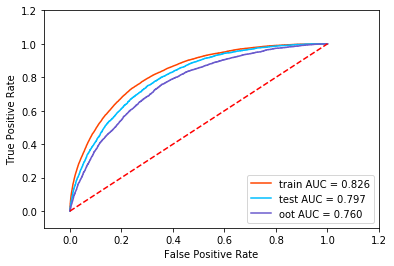

/data1/jupyterhub/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/data1/jupyterhub/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


ks_value is 0.4946 at pop = 0.3716


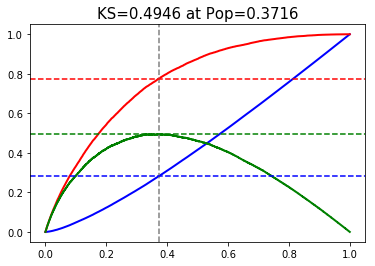

ks_value is 0.4485 at pop = 0.3831


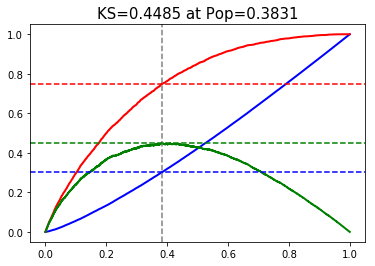

ks_value is 0.4007 at pop = 0.4387


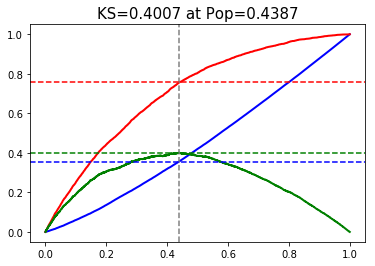

In [252]:
plt.plot(false_positive_rate1, true_positive_rate1, 'b',label='train AUC = %0.3f'% roc_auc1,color='orangered')
plt.plot(false_positive_rate2, true_positive_rate2, 'b',label='test AUC = %0.3f'% roc_auc2,color='deepskyblue')
plt.plot(false_positive_rate3, true_positive_rate3, 'b',label='oot AUC = %0.3f'% roc_auc3,color='slateblue')
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.1,1.2])
plt.ylim([-0.1,1.2])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()
PlotKS(dtrain_predprob1, train_y, n=train_y.shape[0], asc=0)
PlotKS(dtest_predprob2, test_y, n=test_y.shape[0], asc=0)
PlotKS(dtest_predprob3, test_y2['14d'], n=test_y2.shape[0], asc=0)

In [3]:
?cb.CatBoostClassifier()

NameError: name 'feature' is not defined